# **PART 0: RLIBS SETUP**

Load R magic extension & Mount Google Drive

In [2]:
%load_ext rpy2.ipython
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Setup Google Drive directory to R package library

In [3]:
%%R
.libPaths("/content/drive/MyDrive/R_ggColab_Thien/Rlibs")

Load required libraries

In [4]:
%%R
library(GEOquery)
library(curl)
library(minfi)
library(parallel)
library(data.table)
library(qs)
library(knitr)
library(ggplot2)
library(maxprobes)
library(RColorBrewer)
library(IlluminaHumanMethylationEPICmanifest)
library(IlluminaHumanMethylationEPICanno.ilm10b4.hg19)

Loading required package: Biobase
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.

Setting options('download.file.method.GEOquery'='auto')
Setting options('GEOquery.inmemory.gpl'=FALSE)
Using libcurl 7.81.0 with OpenSSL/3.0.2
Loadi

Global Setup

In [5]:
%%R
set.seed(123)
Sys.setenv("VROOM_CONNECTION_SIZE" = 131072 * 1000)  # Increase buffer size
options(timeout = 3600)  # Increase timeout for slow GEO servers

Directory Setup

>[PubMed](https://pubmed.ncbi.nlm.nih.gov/36157320/)


>[Gene Expression Omnibus](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE169622)


In [6]:
%%R
gse_acc <- "GSE169622"
dir_op <- file.path("/content/drive/MyDrive/R_ggColab_Thien", gse_acc)
setwd(dir_op)

dir_op.raw <- file.path(dir_op, "01.Raw")
if (!dir.exists(dir_op.raw)) dir.create(dir_op.raw)

dir_op.qc <- file.path(dir_op, "02.QC")
if (!dir.exists(dir_op.qc)) dir.create(dir_op.qc)

dir_op.methProbes <- file.path(dir_op, "03.methProbes")
if (!dir.exists(dir_op.methProbes)) dir.create(dir_op.methProbes)


# **PART 1: DOWNLOAD DATA**

## 1.1. Retry-Download Function

In [ ]:
%%R
retry_download <- function(url, destfile, method = "wget", max_retries = 5, quiet = TRUE) {
  attempt <- 1
  repeat {
    tryCatch({
      download.file(url, destfile, method = method, quiet = quiet)
      message("Downloaded: ", basename(destfile))
      if (system(paste0("gunzip -t ", destfile)) == 0) return(TRUE)
      stop("Corrupt file")
    }, error = function(e) {
      attempt <- attempt + 1
      if (attempt > max_retries) return(FALSE)
      Sys.sleep(3)
    })
  }
}

## 1.2. Download GEO Metadata

Get Expression set

In [14]:
# %%R
# gse_Info <- getGEO(gse_acc, GSEMatrix = TRUE, destdir = dir_op.raw)
# print(gse_Info)

$GSE169622_series_matrix.txt.gz
ExpressionSet (storageMode: lockedEnvironment)
assayData: 753155 features, 9 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: GSM5211145 GSM5211146 ... GSM5211153 (9 total)
  varLabels: title geo_accession ... sample type:ch1 (39 total)
  varMetadata: labelDescription
featureData
  featureNames: cg00000029 cg00000109 ... cg27666123 (753155 total)
  fvarLabels: ID SPOT_ID ... SourceSeq (14 total)
  fvarMetadata: Column Description labelDescription
experimentData: use 'experimentData(object)'
  pubMedIds: 36157320 
Annotation: GPL21145 



Found 1 file(s)
GSE169622_series_matrix.txt.gz
Using locally cached version: /content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/GSE169622_series_matrix.txt.gz
|--------------------------------------------------|
|==================================================|
Using locally cached version of GPL21145 found here:
/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/GPL21145.soft.gz 
|--------------------------------------------------|
|==================================================|
|--------------------------------------------------|
|==================================================|
|--------------------------------------------------|
|==================================================|


Extract metadata

In [ ]:
# %%R
# metaDT <- pData(phenoData(gse_Info[[1]]))
# print(kable(metaDT))

# fwrite(metaDT, file.path(dir_op.raw, "Metadata.csv"))

In [7]:
%%R
metaDT <- fread(file.path(dir_op.raw, "Metadata.csv"))
print(kable(metaDT))



|title                              |geo_accession |status                |submission_date |last_update_date |type    | channel_count|source_name_ch1          |organism_ch1 |characteristics_ch1 |characteristics_ch1.1 |characteristics_ch1.2 |characteristics_ch1.3          |treatment_protocol_ch1                                                                              |molecule_ch1 |extract_protocol_ch1                                                                                                         |label_ch1   |label_protocol_ch1         | taxid_ch1|hyb_protocol                                                                                                                            |scan_protocol                                                                                                                                     |description            |data_processing          |platform_id |contact_name |contact_email      |contact_institute |contact_address |contact_city |c

Clean and format metadata

In [8]:
%%R
metaDT_Sub <- fread(file.path(dir_op.raw, "Metadata_Sub.csv"))
# metaDT_Sub <- metaDT[, c(1, 8, grep(":ch1", colnames(metaDT)), grep("supplementary_file", colnames(metaDT)))]
# metaDT_Sub <- metaDT[, c(1, 8, grep(":ch1", colnames(metaDT)), grep("supplementary_file", colnames(metaDT)))]
# metaDT_Sub <- as.data.frame(apply(metaDT_Sub, 2, function(x) gsub('\\s+', '_', x)))
# metaDT_Sub$Accession_number <- rownames(metaDT_Sub)
# colnames(metaDT_Sub) <- gsub('\\s+|:ch1', '', colnames(metaDT_Sub))
print(kable(metaDT_Sub))

# fwrite(metaDT_Sub, file.path(dir_op.raw, "Metadata_Sub.csv"))



|title                              |source_name_ch1          |diseasestate    |gender |hpvtype  |sampletype |supplementary_file                                                                                            |supplementary_file.1                                                                                          |Accession_number |
|:----------------------------------|:------------------------|:---------------|:------|:--------|:----------|:-------------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------|:----------------|
|SAMPLE_1:_normal_cervical_sample_1 |genomic_DNA_from_FFPE_1  |normal          |Female |negative |FFPE       |ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5211nnn/GSM5211145/suppl/GSM5211145_201328710023_R01C01_Grn.idat.gz |ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5211nnn/GSM5211145/suppl/GSM52111

## 1.3. Download Raw IDAT Files

We have the download links (FTP protocols) from metadata

In [ ]:
%%R
metaDT_Sub$supplementary_file

[1] "ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5211nnn/GSM5211145/suppl/GSM5211145_201328710023_R01C01_Grn.idat.gz"
[2] "ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5211nnn/GSM5211146/suppl/GSM5211146_201328710023_R02C01_Grn.idat.gz"
[3] "ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5211nnn/GSM5211147/suppl/GSM5211147_201328710023_R03C01_Grn.idat.gz"
[4] "ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5211nnn/GSM5211148/suppl/GSM5211148_201503470047_R04C01_Grn.idat.gz"
[5] "ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5211nnn/GSM5211149/suppl/GSM5211149_201503470047_R05C01_Grn.idat.gz"
[6] "ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5211nnn/GSM5211150/suppl/GSM5211150_201503470047_R06C01_Grn.idat.gz"
[7] "ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5211nnn/GSM5211151/suppl/GSM5211151_201503470047_R07C01_Grn.idat.gz"
[8] "ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5211nnn/GSM5211152/suppl/GSM5211152_201503470047_R08C01_Grn.idat.gz"
[9] "ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5211nnn/GSM5211153/suppl/

How many CPUs we have?

In [ ]:
%%R
detectCores()

[1] 2


Create a folder to store raw idat files

In [ ]:
# %%R
# dir.create(file.path(dir_op.raw, "Idat"), recursive = TRUE)

In addition: Warning message:
In dir.create(file.path(dir_op.raw, "Idat"), recursive = TRUE) :
  '/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat' already exists


Start to download those IDAT files

In [ ]:
# %%R
# mclapply(
#     metaDT_Sub$supplementary_file,
#     mc.cores = 2,
#     function(link_green) {
#         retry_download(link_green, file.path(dir_op.raw, "Idat", basename(link_green)))
#         link_red <- gsub("_Grn\\.idat\\.gz", "_Red\\.idat\\.gz", link_green)
#         retry_download(link_red, file.path(dir_op.raw, "Idat", basename(link_red)))
#         }
#     )

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE



# **PART 2: PROCESS DATA**

>Purpose: Load IDATs, apply QC, filtering, normalization, and prepare methylation matrix for downstream use.

## 2.1. Unzip & Read IDAT Files

In [ ]:
%%R
idat_gz_files <- list.files(file.path(dir_op.raw, "Idat"), pattern = "\\.gz$", full.names = TRUE)
print(idat_gz_files)

 [1] "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211145_201328710023_R01C01_Grn.idat.gz"
 [2] "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211145_201328710023_R01C01_Red.idat.gz"
 [3] "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211146_201328710023_R02C01_Grn.idat.gz"
 [4] "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211146_201328710023_R02C01_Red.idat.gz"
 [5] "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211147_201328710023_R03C01_Grn.idat.gz"
 [6] "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211147_201328710023_R03C01_Red.idat.gz"
 [7] "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211148_201503470047_R04C01_Grn.idat.gz"
 [8] "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211148_201503470047_R04C01_Red.idat.gz"
 [9] "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211149_201503470047_R05C01_Grn.idat.gz"
[

In [ ]:
# %%R
# sapply(idat_gz_files, R.utils::gunzip, overwrite = TRUE, remove = FALSE)

/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211145_201328710023_R01C01_Grn.idat.gz 
 "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211145_201328710023_R01C01_Grn.idat" 
/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211145_201328710023_R01C01_Red.idat.gz 
 "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211145_201328710023_R01C01_Red.idat" 
/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211146_201328710023_R02C01_Grn.idat.gz 
 "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211146_201328710023_R02C01_Grn.idat" 
/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211146_201328710023_R02C01_Red.idat.gz 
 "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211146_201328710023_R02C01_Red.idat" 
/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211147_201328710023_R03C01_Grn.idat.gz 
 "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.R

In [ ]:
%%R
idat_basenames <- unique(gsub("_Grn.*|_Red.*", "", idat_gz_files))
print(idat_basenames)

[1] "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211145_201328710023_R01C01"
[2] "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211146_201328710023_R02C01"
[3] "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211147_201328710023_R03C01"
[4] "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211148_201503470047_R04C01"
[5] "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211149_201503470047_R05C01"
[6] "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211150_201503470047_R06C01"
[7] "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211151_201503470047_R07C01"
[8] "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211152_201503470047_R08C01"
[9] "/content/drive/MyDrive/R_ggColab_Thien/GSE169622/01.Raw/Idat/GSM5211153_201503670097_R07C01"


In [ ]:
%%R
rgSet <- read.metharray(basenames = idat_basenames, force = TRUE)
print(rgSet)

class: RGChannelSet 
dim: 1051539 9 
metadata(0):
assays(2): Green Red
rownames(1051539): 1600101 1600111 ... 99810990 99810992
rowData names(0):
colnames(9): GSM5211145_201328710023_R01C01
  GSM5211146_201328710023_R02C01 ... GSM5211152_201503470047_R08C01
  GSM5211153_201503670097_R07C01
colData names(0):
Annotation
  array: IlluminaHumanMethylationEPIC
  annotation: ilm10b4.hg19


In [ ]:
# %%R
# sampleNames(rgSet) <- metaDT_Sub$title
# print(rgSet)
# qsave(rgSet, file.path(dir_op.raw, "rgSet.RDS"))

In [ ]:
%%R
rgSet <- qread(file.path(dir_op.raw, "rgSet.RDS"))
sampleNames(rgSet) <- metaDT_Sub$title
print(rgSet)

class: RGChannelSet 
dim: 1051539 9 
metadata(0):
assays(2): Green Red
rownames(1051539): 1600101 1600111 ... 99810990 99810992
rowData names(0):
colnames(9): SAMPLE_1:_normal_cervical_sample_1
  SAMPLE_2:_normal_cervical_sample_2 ... SAMPLE_8:_cervical_cancer_5
  SAMPLE_9:_cervical_cancer_6
colData names(0):
Annotation
  array: IlluminaHumanMethylationEPIC
  annotation: ilm10b4.hg19


## 2.2. Normalize, QC, and Filter

Detection P-value

In [ ]:
%%R
detP <- detectionP(rgSet)
print(kable(head(detP)))
# fwrite(detP, file.path(dir_op.qc, "detP.csv"))



|           | SAMPLE_1:_normal_cervical_sample_1| SAMPLE_2:_normal_cervical_sample_2| SAMPLE_3:_normal_cervical_sample_3| SAMPLE_4:_cervical_cancer_1| SAMPLE_5:_cervical_cancer_2| SAMPLE_6:_cervical_cancer_3| SAMPLE_7:_cervical_cancer_4| SAMPLE_8:_cervical_cancer_5| SAMPLE_9:_cervical_cancer_6|
|:----------|----------------------------------:|----------------------------------:|----------------------------------:|---------------------------:|---------------------------:|---------------------------:|---------------------------:|---------------------------:|---------------------------:|
|cg18478105 |                                  0|                                  0|                                  0|                           0|                           0|                           0|                           0|                           0|                           0|
|cg09835024 |                                  0|                                  0|                         

x being coerced from class: matrix to data.table


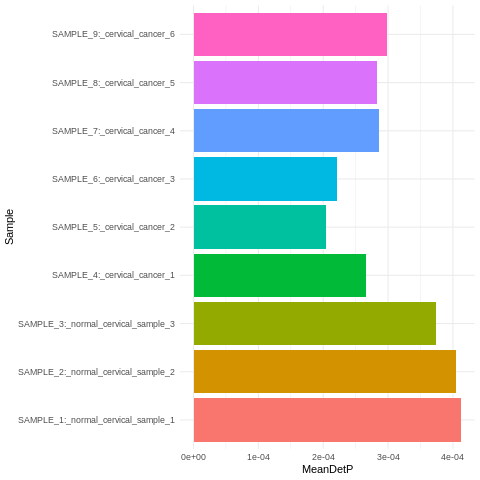

In [ ]:
%%R
ggplot(data.frame(Sample = names(colMeans(detP)),
                  MeanDetP = colMeans(detP)),
       aes(x = MeanDetP, y = Sample, fill = Sample)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  theme(legend.position = "none")

Normalize

class: GenomicRatioSet 
dim: 865859 9 
metadata(0):
assays(2): M CN
rownames(865859): cg14817997 cg26928153 ... cg07587934 cg16855331
rowData names(0):
colnames(9): SAMPLE_1:_normal_cervical_sample_1
  SAMPLE_2:_normal_cervical_sample_2 ... SAMPLE_8:_cervical_cancer_5
  SAMPLE_9:_cervical_cancer_6
colData names(3): xMed yMed predictedSex
Annotation
  array: IlluminaHumanMethylationEPIC
  annotation: ilm10b4.hg19
Preprocessing
  Method: Raw (no normalization or bg correction)
  minfi version: 1.52.1
  Manifest version: 0.3.0


[preprocessQuantile] Mapping to genome.
[preprocessQuantile] Fixing outliers.
[preprocessQuantile] Quantile normalizing.
In addition: Warning message:
In .getSex(CN = CN, xIndex = xIndex, yIndex = yIndex, cutoff = cutoff) :
  An inconsistency was encountered while determining sex. One possibility is that only one sex is present. We recommend further checks, for example with the plotSex function.


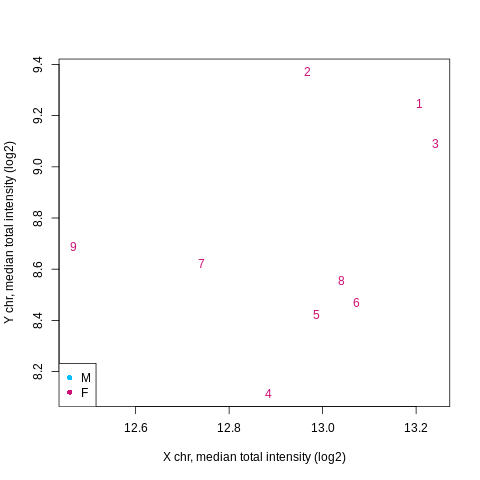

In [ ]:
%%R
mSetSq <- preprocessQuantile(rgSet)
print(mSetSq)
plotSex(mSetSq)

Filter Probes 1: P-value

In [ ]:
%%R
detP <- detP[match(featureNames(mSetSq), rownames(detP)), ]
mSetSqFlt <- mSetSq[rowSums(detP < 0.05) == ncol(mSetSq), ]
nRemovedProbe_FilterP <- nrow(mSetSq) - nrow(mSetSqFlt)

Filter Probes 2: SNPs

In [ ]:
%%R
n_tmp <- nrow(mSetSqFlt)
mSetSqFlt <- dropLociWithSnps(mSetSqFlt)
nRemovedProbe_FilterSNPs <- n_tmp - nrow(mSetSqFlt)

Filter Probes 3: Cross-reactive

In [ ]:
%%R
n_tmp <- nrow(mSetSqFlt)
mSetSqFlt <- dropXreactiveLoci(mSetSqFlt)
nRemovedProbe_FilterCrX <- n_tmp - nrow(mSetSqFlt)

Filter Probes 4: non-CpG

In [ ]:
%%R
nRemovedProbe_nonCpG <- sum(grepl("^ch", rownames(mSetSqFlt)))
mSetSqFlt <- mSetSqFlt[!grepl("^ch", rownames(mSetSqFlt))]
print(mSetSqFlt)
qsave(mSetSqFlt, file.path(dir_op.methProbes, "mSetSqFlt.RDS"))
nProbe_FurtherUse <- nrow(mSetSqFlt)

class: GenomicRatioSet 
dim: 790828 9 
metadata(0):
assays(2): M CN
rownames(790828): cg26928153 cg16269199 ... cg21106100 cg08265308
rowData names(0):
colnames(9): SAMPLE_1:_normal_cervical_sample_1
  SAMPLE_2:_normal_cervical_sample_2 ... SAMPLE_8:_cervical_cancer_5
  SAMPLE_9:_cervical_cancer_6
colData names(3): xMed yMed predictedSex
Annotation
  array: IlluminaHumanMethylationEPIC
  annotation: ilm10b4.hg19
Preprocessing
  Method: Raw (no normalization or bg correction)
  minfi version: 1.52.1
  Manifest version: 0.3.0


Plot filter summary

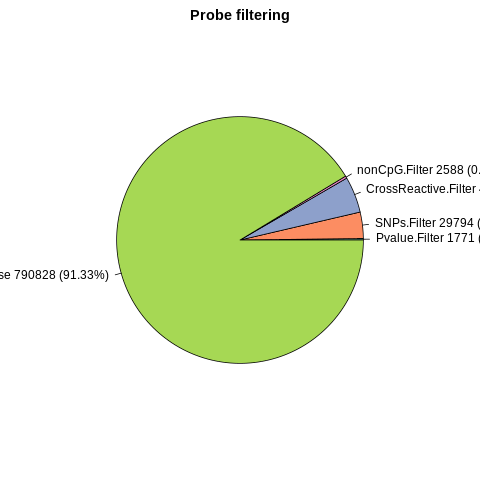

In [ ]:
%%R
df.cgFiltered <- data.frame(
  Pvalue.Filter = nRemovedProbe_FilterP,
  SNPs.Filter = nRemovedProbe_FilterSNPs,
  CrossReactive.Filter = nRemovedProbe_FilterCrX,
  nonCpG.Filter = nRemovedProbe_nonCpG,
  FurtherUse = nProbe_FurtherUse
)
# fwrite(df.cgFiltered, file.path(dir_op.qc, "nCpG_Filtered.csv"))

dfpie <- t(df.cgFiltered)
pie_labels <- paste0(rownames(dfpie), " ", dfpie[,1], " (", round(100 * dfpie[,1]/sum(dfpie[,1]), 2), "%)")
par(mar = c(2, 5, 2, 5) + 0.1) #(bottom, left, top, right)
pie(dfpie, main="Probe filtering", labels = pie_labels, col = brewer.pal(nrow(dfpie), "Set2"))

## 2.3. Get Methylation Matrix

β-value = M/(M + U)

M-value = log2(M/U)

[Learn more](https://nbis-workshop-epigenomics.readthedocs.io/en/latest/content/tutorials/methylationArray/Array_Tutorial.html#a-note-on-class-structure)

In [ ]:
%%R
# mSetSqFlt <- qread(file.path(dir_op.methProbes, "mSetSqFlt.RDS"))
bVals <- getBeta(mSetSqFlt)
bVals <- bVals[complete.cases(bVals), ]
bVals <- apply(bVals, 2, function(x) round(x, 2))
print(kable(bVals[1:5, 1:3]))



|           | SAMPLE_1:_normal_cervical_sample_1| SAMPLE_2:_normal_cervical_sample_2| SAMPLE_3:_normal_cervical_sample_3|
|:----------|----------------------------------:|----------------------------------:|----------------------------------:|
|cg26928153 |                               0.82|                               0.84|                               0.83|
|cg16269199 |                               0.71|                               0.71|                               0.67|
|cg13869341 |                               0.82|                               0.83|                               0.81|
|cg24669183 |                               0.78|                               0.77|                               0.80|
|cg26679879 |                               0.22|                               0.21|                               0.42|


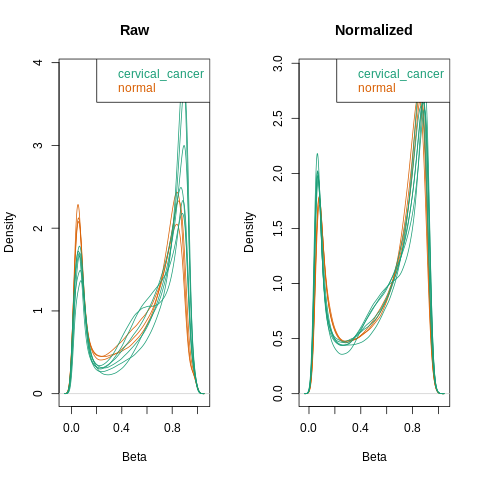

In [ ]:
%%R
par(mfrow = c(1, 2))  # 1 row, 2 columns layout
densityPlot(rgSet, sampGroups = metaDT_Sub$diseasestate, main = "Raw")
densityPlot(bVals, sampGroups = metaDT_Sub$diseasestate, main = "Normalized")

## 2.4. Merge with Probe Location

In [ ]:
%%R
EPIChg19.anno <- getLocations(IlluminaHumanMethylationEPICanno.ilm10b4.hg19)
print(EPIChg19.anno)

GRanges object with 865859 ranges and 0 metadata columns:
             seqnames    ranges strand
                <Rle> <IRanges>  <Rle>
  cg18478105    chr20  61847650      *
  cg09835024     chrX  24072640      *
  cg14361672     chr9 131463936      *
  cg01763666    chr17  80159506      *
  cg12950382    chr14 105176736      *
         ...      ...       ...    ...
  cg23079522     chr3 160569628      *
  cg16818145     chr3 182782277      *
  cg14585103     chr8 139940608      *
  cg10633746    chr17  18164442      *
  cg12623625     chr1  17946923      *
  -------
  seqinfo: 24 sequences from hg19 genome; no seqlengths


In [ ]:
%%R
EPIChg19.anno.df <- as.data.frame(EPIChg19.anno)
EPIChg19.anno.df$probeID <- rownames(EPIChg19.anno.df)

In [ ]:
%%R
bigTable <- as.data.frame(bVals)
bigTable$probeID <- row.names(bigTable)

bigTable <- base::merge(EPIChg19.anno.df, bigTable, by = "probeID", all.x = FALSE, all.y = TRUE)
bigTable <- dplyr::arrange(bigTable, seqnames, probeID)

print(kable(bigTable[1:10, 1:10]))



|probeID    |seqnames |     start|       end| width|strand | SAMPLE_1:_normal_cervical_sample_1| SAMPLE_2:_normal_cervical_sample_2| SAMPLE_3:_normal_cervical_sample_3| SAMPLE_4:_cervical_cancer_1|
|:----------|:--------|---------:|---------:|-----:|:------|----------------------------------:|----------------------------------:|----------------------------------:|---------------------------:|
|cg00000165 |chr1     |  91194674|  91194674|     1|*      |                               0.18|                               0.16|                               0.17|                        0.38|
|cg00000363 |chr1     | 230560793| 230560793|     1|*      |                               0.16|                               0.20|                               0.18|                        0.29|
|cg00000540 |chr1     |  28462664|  28462664|     1|*      |                               0.71|                               0.75|                               0.79|                        0.73|
|cg00000

In [ ]:
# %%R
# fwrite(bigTable, file.path(dir_op.methProbes, "bigTable.hg19.tsv"), sep = "\t", col.names = TRUE, quote = FALSE, row.names = FALSE)